In [ ]:
import torch
import random
import numpy as np


random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Распаковка датасета
import tarfile
from google.colab import files
tar = tarfile.open("/content/gdrive/MyDrive/Colab Notebooks/cats_dogs_dataset.tar", "r")
tar.extractall('/content')

In [ ]:
# Функция для вывода первых 5 изображений
def image_shower(images, labels, n=5):
    plt.figure(figsize=(12, 12))
    for i, image in enumerate(images[:n]):
        plt.subplot(n, n, i + 1)
        image = image/ 2 + 0.5
        plt.imshow(image.numpy().transpose((1, 2, 0)).squeeze())
    print(label for label in labels[:n])

# Путь до датасета
PATH = "/content/cats_dogs_dataset/"

In [ ]:
# Создание вложенных подпапок для train и valid (костыль)
import os


os.rename(PATH + "/valid", PATH + "/1")
os.mkdir(PATH + '/valid')
os.rename(PATH + "/1", PATH + "/valid/1")
os.rename(PATH + "/train", PATH + "/1")
os.mkdir(PATH + '/train')
os.rename(PATH + "/1", PATH + "/train/1")

In [ ]:
import re
import os
import natsort
from PIL import Image


# Получение списка для разметки изображений
def get_rols(path):
  list_of_rols = []
  for root, dirs, files in os.walk(path): 
      # Сортиворка имен файлов 
      files = natsort.natsorted(files)
      for filename in files:
        if re.findall(r'.txt', filename):
            with open(path + '/' + filename) as f:
              im = Image.open(path + "/" + filename[:-3] + "jpg")
              (width, height) = im.size
              temp_list = [int(num) for num in f.readline().split()]
              #  Нормирование координат
              temp_list[1] = round(temp_list[1] / width, 2)
              temp_list[2] = round(temp_list[2] / height, 2)
              temp_list[3] = round(temp_list[3] / width, 2)
              temp_list[4] = round(temp_list[4] / height, 2)
              list_of_rols.append(temp_list)
  return list_of_rols

In [ ]:
import torchvision
import torchvision.transforms as transforms


# Преобразования изображений
transform = transforms.Compose(
    # Размер изображений
    [transforms.Resize((220, 220)),
    #  Перевод в тензор
     transforms.ToTensor(),
    #  Нормализация
     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

trainset = torchvision.datasets.ImageFolder(os.path.join(PATH, "train"), transform=transform)
list_of_data_1 = []
list_of_rols = get_rols('/content/cats_dogs_dataset/train/1')
# Составление списка картинок с разметками для тренировки (еще костыль)
for i in range(len(trainset)):
  list_of_data_1.append((trainset[i][0], list_of_rols[i]))
trainloader = torch.utils.data.DataLoader(list_of_data_1, batch_size=64, num_workers=0, shuffle=True)

testset = torchvision.datasets.ImageFolder(os.path.join(PATH, "valid"), transform=transform)
list_of_data_2 = []
list_of_rols = get_rols('/content/cats_dogs_dataset/valid/1')
# Составление списка картинок с разметками для тестирования
for j in range(len(testset)):
  list_of_data_2.append((testset[j][0], list_of_rols[j]))
testloader = torch.utils.data.DataLoader(list_of_data_2, batch_size=64, num_workers=0, shuffle=True)



<generator object image_shower.<locals>.<genexpr> at 0x7fb14fa87f50>


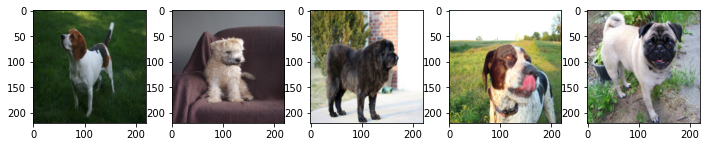

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from tqdm import tqdm

%matplotlib inline


images, labels = next(iter(testloader))
image_shower(images, labels)

In [ ]:
# Загрузка ResNet18
model = torchvision.models.resnet18(pretrained=True)
# Заморозка весов сети
for param in model.parameters():
    param.require = False

# Устанавливаем 5 выходов
model.fc = nn.Linear(512, 5)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
# Зададим функцию потерь и оптимизатор

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum=0.9)

# loss = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=3.0e-4)

# loss = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)

In [ ]:
#определим устройство, где проводить вычисления (GPU или CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
epochs = 4   # Судя по Training loss двух эпох достаточно, перестраховался
model.to(device) # Переносим модель на GPU

for epoch in range(epochs):
    running_loss = 0.0
    for i, data in tqdm(enumerate(trainloader)):
        inputs, labels = data[0].to(device), data[1][0].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print ("Epoch {} - Training loss: {} ".format(epoch, running_loss/len(trainloader)))

47it [12:26, 15.89s/it]
0it [00:00, ?it/s]

Epoch 0 - Training loss: 0.2786029360871366 


47it [12:22, 15.80s/it]
0it [00:00, ?it/s]

Epoch 1 - Training loss: 0.05224830478905363 


47it [12:21, 15.78s/it]
0it [00:00, ?it/s]

Epoch 2 - Training loss: 0.033966623028700654 


47it [12:21, 15.77s/it]

Epoch 3 - Training loss: 0.022006059362691767 


In [ ]:
# Считаем точность
correct = 0
total = 0
with torch.no_grad():
    model.eval()
    for data in testloader:
        inputs, labels = data[0].to(device), data[1][0].to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print("Accuracy: %d" %(100 * correct/total))

Accuracy: 99
